In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from kerastuner.tuners import RandomSearch
from tqdm import tqdm
import cv2
import os
import numpy as np

IMAGE_SIZE = (150, 150)

def average_filter(image):
    kernel = np.ones((3, 3), np.float32) / 9
    return cv2.filter2D(image, -1, kernel)

def build_model(hp):
    model = tf.keras.Sequential()
    
    model.add(Conv2D(filters=hp.Int('conv_1_filter', min_value=8, max_value=32, step=8),
                     kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),
                     activation='relu',
                     input_shape=(150, 150, 3)))
    model.add(MaxPooling2D((2, 2)))
    
    for i in range(hp.Int('num_hidden_layers', 1, 2)):
        model.add(Conv2D(filters=hp.Int(f'conv_{i+2}_filter', min_value=8, max_value=32, step=8),
                         kernel_size=hp.Choice(f'conv_{i+2}_kernel', values=[3, 5]),
                         activation='relu'))
        model.add(MaxPooling2D((2, 2)))
    
    model.add(Flatten())
    
    model.add(Dense(units=hp.Int('dense_units', min_value=32, max_value=64, step=32),
                    activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(5, activation='softmax'))
    
    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-3, 1e-4])),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

def load_data(data_dir, class_names_label):
    images = []
    labels = []
    
    # 지정된 데이터 디렉터리 내의 각 폴더(클래스)를 순회
    for folder in os.listdir(data_dir):
        if folder in class_names_label:
            label = class_names_label[folder] 
        else:
            continue
        
        folder_path = os.path.join(data_dir, folder)
        
        # 각 폴더 내의 이미지를 순회
        for file in tqdm(os.listdir(folder_path)):
            img_path = os.path.join(folder_path, file)
            
            # 이미지를 읽고 크기를 조정
            image = cv2.imread(img_path)
            if image is None:
                continue
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, IMAGE_SIZE)
            
            # 정규화: 0 ~ 255 범위의 픽셀 값을 0 ~ 1 범위로 변환
            image = image / 255.0

            # 평균 필터 적용
            image = average_filter(image)
            
            images.append(image)
            labels.append(label)
    
    images = np.array(images, dtype='float32')
    labels = np.array(labels, dtype='int32')

    # 데이터 증강
    images = augment_images(images)
    labels = augment_labels(labels)

    # 데이터 셔플
    images, labels = shuffle_data(images, labels)
    
    return images, labels

def augment_images(images):
    augmented_images = []
    for image in images:
        augmented_images.append(image)
        augmented_images.append(np.fliplr(image))  # 좌우 반전
        augmented_images.append(np.flipud(image))  # 상하 반전
    return np.array(augmented_images)

def augment_labels(labels):
    augmented_labels = []
    for label in labels:
        augmented_labels.extend([label] * 3)  # 각 이미지에 대해 세 개의 라벨
    return np.array(augmented_labels)

def shuffle_data(images, labels):
    indices = np.arange(images.shape[0])
    np.random.shuffle(indices)
    return images[indices], labels[indices]

def load_data(data_dir, class_names_label):
    datasets = ["train"]
    output = []

    for dataset in datasets:
        images = []
        labels = []

        print("Loading {}".format(dataset))
        # 지정된 데이터 디렉터리 내의 각 폴더(클래스)를 순회
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # 각 폴더 내의 이미지를 순회
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # 이미지를 읽고 크기를 조정
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE)
                
                # 정규화: 0 ~ 255 범위의 픽셀 값을 0 ~ 1 범위로 변환
                image = image / 255

                # 평균 필터 적용
                image = average_filter(image)
                
                images.append(image)
                labels.append(label)
        
        images = np.array(images, dtype='float32')
        labels = np.array(labels, dtype='int32')

        # 데이터 증강
        images = augment_images(images)
        labels = augment_labels(labels)

        # 데이터 셔플
        images, labels = shuffle_data(images, labels)
        output.append((images, labels))
    return output

def evaluate_model(model, test_images, test_labels):
    test_loss, test_accuracy = model.evaluate(test_images, test_labels)
    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: {test_accuracy}")

    predictions = model.predict(test_images)
    return predictions

data_dir = 'C:/Users/USER/OneDrive/Desktop/머신러닝실습/텀프로젝트/train'  # 데이터가 저장된 디렉토리 경로
class_names_label = {
    'buildings': 0,
    'forest': 1,
    'glacier': 2,
    'mountain': 3,
    'sea': 4 }

output = load_data(data_dir, class_names_label)


# 최적의 하이퍼파라미터로 모델 훈련
model = 
history = model.fit(output[0][0], output[0][1], epochs=50, validation_split = 0.2, batch_size=32)

# 모델 요약 출력
model.summary()



Trial 5 Complete [00h 05m 44s]
val_accuracy: 0.7138888835906982

Best val_accuracy So Far: 0.7138888835906982
Total elapsed time: 00h 13m 19s

The hyperparameter search is complete. 
The optimal number of filters in the first convolutional layer is 32 with a kernel size of 3.
The optimal number of hidden layers is 1.
The optimal number of units in the dense layer is 64.
The optimal learning rate for the optimizer is 0.0001.

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - accuracy: 0.2262 - loss: 1.6388 - val_accuracy: 0.3750 - val_loss: 1.5745
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - accuracy: 0.2636 - loss: 1.5781 - val_accuracy: 0.5083 - val_loss: 1.5019
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - accuracy: 0.4113 - loss: 1.4614 - val_accuracy: 0.4500 - val_loss: 1.4021
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 0.4711 - loss: 1.3640 - val_accuracy: 0.5083 - val_loss: 1.3335
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accur

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 70, 70, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 35, 35, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 39200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │     2,508,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,607,153 (29.02 MB)

 Trainable params: 2,535,717 (9.67 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,071,436 (19.35 MB)

FileNotFoundError: [WinError 3] 지정된 경로를 찾을 수 없습니다: 'C:/Users/USER/OneDrive/Desktop/train'

Loading train


100%|██████████| 40/40 [00:00<00:00, 1227.52it/s]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9192 - loss: 0.3198
Test Loss: 0.30753669142723083
Test Accuracy: 0.9283333420753479
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


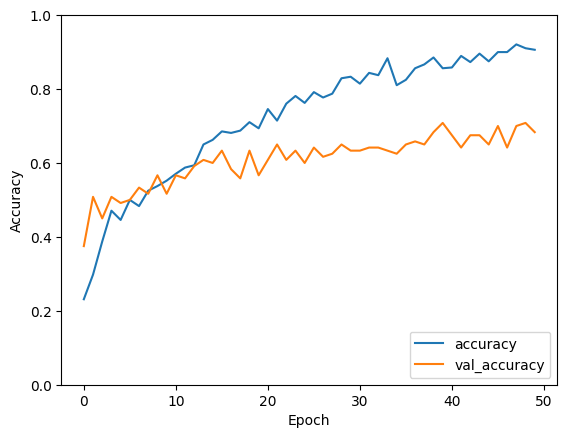

In [8]:
# 테스트 데이터 로드
test_data_dir = 'C:/Users/USER/OneDrive/Desktop/train'  # 테스트 데이터가 저장된 디렉토리 경로
test_outputs = load_data(test_data_dir, class_names_label)

# 모델 평가
predictions = evaluate_model(model, test_outputs[0][0], test_outputs[0][1])

# 학습 결과 시각화
import matplotlib.pyplot as plt

def plot_history(history):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.show()

plot_history(history)
